# WeightWatcher ResNet

https://calculationconsulting.com

### Analysis of pyTorch 

In [1]:
# Suppress the powerlaw package warnings
# "powerlaw.py:700: RuntimeWarning: divide by zero encountered in true_divide"
# "powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide"
import warnings
warnings.simplefilter(action='ignore', category=RuntimeWarning)

In [86]:
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

### Import WeightWatcher

set custom Logging at WARN Level

In [24]:
import logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)
logger.setLevel(logging.WARN)

import weightwatcher as ww
import torchvision.models as models

ww.__version__


'0.2.1'

### Create all models now

In [25]:

all_names = [ 'resnet18', 'resnet34', 'resnet50', 'resnet101','resnet152']
#'resnext50_32x4d', 'resnext101_32x8d', 'wide_resnet50_2', 'wide_resnet101_2']

all_models = []
all_models.append(models.resnet18(pretrained=True))
all_models.append(models.resnet34(pretrained=True))
all_models.append(models.resnet50(pretrained=True))
all_models.append(models.resnet101(pretrained=True))
all_models.append(models.resnet152(pretrained=True))




Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /Users/charleshmartin/.torch/models/resnet34-333f7ec4.pth
87306240it [00:08, 10184021.32it/s]
Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /Users/charleshmartin/.torch/models/resnet50-19c8e357.pth
102502400it [00:11, 8861020.75it/s] 
Downloading: "https://download.pytorch.org/models/resnet101-5d3b4d8f.pth" to /Users/charleshmartin/.torch/models/resnet101-5d3b4d8f.pth
178728960it [00:17, 10122365.50it/s]
Downloading: "https://download.pytorch.org/models/resnet152-b121ed2d.pth" to /Users/charleshmartin/.torch/models/resnet152-b121ed2d.pth
241530880it [00:43, 5586961.08it/s] 


### Get reported accuracies from pytorch website

https://pytorch.org/docs/stable/torchvision/models.html

<pre>
<table class="docutils align-default">
<colgroup>
<col style="width: 55%" />
<col style="width: 22%" />
<col style="width: 22%" />
</colgroup>
<thead>
<thead>
<tr class="row-odd"><th class="head"><p>Network</p></th>
<th class="head"><p>Top-1 error</p></th>
<th class="head"><p>Top-5 error</p></th>
</tr>
</thead>
<tbody>

<tr class="row-odd"><td><p>ResNet-18</p></td>
<td><p>30.24</p></td>
<td><p>10.92</p></td>
</tr>
<tr class="row-even"><td><p>ResNet-34</p></td>
<td><p>26.70</p></td>
<td><p>8.58</p></td>
</tr>
<tr class="row-odd"><td><p>ResNet-50</p></td>
<td><p>23.85</p></td>
<td><p>7.13</p></td>
</tr>
<tr class="row-even"><td><p>ResNet-101</p></td>
<td><p>22.63</p></td>
<td><p>6.44</p></td>
</tr>
<tr class="row-odd"><td><p>ResNet-152</p></td>
<td><p>21.69</p></td>
<td><p>5.94</p></td>
</tr>

</tbody>
</table>
</pre>

In [61]:
top1_errors= {
    
    "resnet18": 30.24,
    "resnet34": 26.70,
    "resnet50": 23.85,
    "resnet101": 22.63,
    "resnet152": 21.69 

}

In [62]:
top5_errors= {
    
    "resnet18": 10.92,
    "resnet34": 8.58,
    "resnet50": 7.13,
    "resnet101": 6.44,
    "resnet152": 5.94    

}

### Run WeightWatcher, collect all details (as dataframes)

In [72]:
all_details = []

for im, name in enumerate(all_names):
    watcher = ww.WeightWatcher(model=all_models[im])
    results = watcher.analyze(alphas=True, softranks=True, spectralnorms=True, mp_fit=True)

    details  = watcher.get_details(results=results)
    details.drop(columns=['slice', 'slice_count'], inplace=True)
    details.dropna(inplace=True)
    details['NxM'] = pd.to_numeric(details.N * details.M)

    all_details.append(details)

2019-12-25 15:12:39,267 INFO 

python      version 3.7.3 (default, Mar 27 2019, 16:54:48) 
[Clang 4.0.1 (tags/RELEASE_401/final)]
numpy       version 1.16.4
tensforflow version 1.13.1
keras       version 2.2.4
INFO:weightwatcher.weightwatcher:

python      version 3.7.3 (default, Mar 27 2019, 16:54:48) 
[Clang 4.0.1 (tags/RELEASE_401/final)]
numpy       version 1.16.4
tensforflow version 1.13.1
keras       version 2.2.4
2019-12-25 15:12:39,269 INFO Analyzing model
INFO:weightwatcher.weightwatcher:Analyzing model
2019-12-25 15:13:46,629 INFO ### Printing results ###
INFO:weightwatcher.weightwatcher:### Printing results ###
2019-12-25 15:13:49,359 INFO Norm: min: 2.1772398948669434, max: 49.700775146484375, avg: 5.529301643371582
INFO:weightwatcher.weightwatcher:Norm: min: 2.1772398948669434, max: 49.700775146484375, avg: 5.529301643371582
2019-12-25 15:13:49,360 INFO Norm compound: min: 2.7893476486206055, max: 49.700775146484375, avg: 7.832644462585449
INFO:weightwatcher.weightwatcher:

INFO:weightwatcher.weightwatcher:Alpha Weighted: min: -1.735479202366478, max: 6.198481393660566, avg: 0.6106765159701216
2019-12-25 15:13:52,127 INFO Alpha Weighted compound: min: -0.4932892978665104, max: 6.198481393660566, avg: 0.958536395694151
INFO:weightwatcher.weightwatcher:Alpha Weighted compound: min: -0.4932892978665104, max: 6.198481393660566, avg: 0.958536395694151
2019-12-25 15:13:52,128 INFO Spectral Norm: min: 0.18535013496875763, max: 71.3998031616211, avg: 2.349897861480713
INFO:weightwatcher.weightwatcher:Spectral Norm: min: 0.18535013496875763, max: 71.3998031616211, avg: 2.349897861480713
2019-12-25 15:13:52,129 INFO Spectral Norm compound: min: 0.7913480997085571, max: 71.3998031616211, avg: 5.337505340576172
INFO:weightwatcher.weightwatcher:Spectral Norm compound: min: 0.7913480997085571, max: 71.3998031616211, avg: 5.337505340576172
2019-12-25 15:13:52,130 INFO Softrank: min: 4.0747111250080685, max: 70.98464745558454, avg: 18.904574346978933
INFO:weightwatcher.w

2019-12-25 15:19:07,123 INFO Softrank Log compound: min: 0.7901865759384852, max: 1.926555666298244, avg: 1.2706811416731179
INFO:weightwatcher.weightwatcher:Softrank Log compound: min: 0.7901865759384852, max: 1.926555666298244, avg: 1.2706811416731179
2019-12-25 15:19:07,125 INFO Softrank Log Ratio: min: -790.8534226841987, max: 923.4677957464274, avg: 6.646287990753862
INFO:weightwatcher.weightwatcher:Softrank Log Ratio: min: -790.8534226841987, max: 923.4677957464274, avg: 6.646287990753862
2019-12-25 15:19:07,125 INFO Softrank Log Ratio compound: min: -87.25331314715724, max: 133.85448367514834, avg: 6.345387584418537
INFO:weightwatcher.weightwatcher:Softrank Log Ratio compound: min: -87.25331314715724, max: 133.85448367514834, avg: 6.345387584418537
2019-12-25 15:19:07,126 INFO Marchenko-Pastur (MP) fit sigma: min: 0.3545312500000001, max: 1.00673828125, avg: 0.8365824911039171
INFO:weightwatcher.weightwatcher:Marchenko-Pastur (MP) fit sigma: min: 0.3545312500000001, max: 1.00673

INFO:weightwatcher.weightwatcher:aka, percent_mass, Number of spikes / total number of evals compound: min: 0.0, max: 0.4246575342465753, avg: 0.0284481590446333
2019-12-25 15:19:12,263 INFO Softrank for MP fit: min: 0.05064334873555934, max: 10.620457156014712, avg: 4.14070747792801
INFO:weightwatcher.weightwatcher:Softrank for MP fit: min: 0.05064334873555934, max: 10.620457156014712, avg: 4.14070747792801
2019-12-25 15:19:12,264 INFO Softrank for MP fit compound: min: 0.05064334873555934, max: 7.69174207836699, avg: 3.758744535921494
INFO:weightwatcher.weightwatcher:Softrank for MP fit compound: min: 0.05064334873555934, max: 7.69174207836699, avg: 3.758744535921494
2019-12-25 15:19:12,592 INFO 

python      version 3.7.3 (default, Mar 27 2019, 16:54:48) 
[Clang 4.0.1 (tags/RELEASE_401/final)]
numpy       version 1.16.4
tensforflow version 1.13.1
keras       version 2.2.4
INFO:weightwatcher.weightwatcher:

python      version 3.7.3 (default, Mar 27 2019, 16:54:48) 
[Clang 4.0.1 (tag

2019-12-25 15:21:01,381 INFO Alpha: min: 1.410442189673097, max: 11.751675990960484, avg: 3.398341269735938
INFO:weightwatcher.weightwatcher:Alpha: min: 1.410442189673097, max: 11.751675990960484, avg: 3.398341269735938
2019-12-25 15:21:01,382 INFO Alpha compound: min: 1.5473492881498399, max: 10.44599942007523, avg: 4.317883910398682
INFO:weightwatcher.weightwatcher:Alpha compound: min: 1.5473492881498399, max: 10.44599942007523, avg: 4.317883910398682
2019-12-25 15:21:01,383 INFO Alpha Weighted: min: -4.494847523187103, max: 6.224596262279313, avg: 0.14039146521640436
INFO:weightwatcher.weightwatcher:Alpha Weighted: min: -4.494847523187103, max: 6.224596262279313, avg: 0.14039146521640436
2019-12-25 15:21:01,384 INFO Alpha Weighted compound: min: -2.0427546310421185, max: 6.224596262279313, avg: 1.3712280505775467
INFO:weightwatcher.weightwatcher:Alpha Weighted compound: min: -2.0427546310421185, max: 6.224596262279313, avg: 1.3712280505775467
2019-12-25 15:21:01,385 INFO Spectral No

2019-12-25 15:24:27,733 INFO Softrank compound: min: 2.531427331167857, max: 107.96141467480516, avg: 25.548839395594044
INFO:weightwatcher.weightwatcher:Softrank compound: min: 2.531427331167857, max: 107.96141467480516, avg: 25.548839395594044
2019-12-25 15:24:27,734 INFO Softrank Log: min: 0.15292126510776372, max: 2.0332685667091943, avg: 1.1721840923725977
INFO:weightwatcher.weightwatcher:Softrank Log: min: 0.15292126510776372, max: 2.0332685667091943, avg: 1.1721840923725977
2019-12-25 15:24:27,735 INFO Softrank Log compound: min: 0.37932502435504106, max: 2.0332685667091943, avg: 1.2945920305552994
INFO:weightwatcher.weightwatcher:Softrank Log compound: min: 0.37932502435504106, max: 2.0332685667091943, avg: 1.2945920305552994
2019-12-25 15:24:27,736 INFO Softrank Log Ratio: min: -59.914144423788144, max: 188.82438954531344, avg: 1.057978345963922
INFO:weightwatcher.weightwatcher:Softrank Log Ratio: min: -59.914144423788144, max: 188.82438954531344, avg: 1.057978345963922
2019-1

INFO:weightwatcher.weightwatcher:Number of spikes per MP fit compound: min: 0.0, max: 309.0, avg: 32.69230769230769
2019-12-25 15:24:36,645 INFO aka, percent_mass, Number of spikes / total number of evals: min: 0.0, max: 0.47619047619047616, avg: 0.033414687546039226
INFO:weightwatcher.weightwatcher:aka, percent_mass, Number of spikes / total number of evals: min: 0.0, max: 0.47619047619047616, avg: 0.033414687546039226
2019-12-25 15:24:36,646 INFO aka, percent_mass, Number of spikes / total number of evals compound: min: 0.0, max: 0.47619047619047616, avg: 0.11823658670136956
INFO:weightwatcher.weightwatcher:aka, percent_mass, Number of spikes / total number of evals compound: min: 0.0, max: 0.47619047619047616, avg: 0.11823658670136956
2019-12-25 15:24:36,647 INFO Softrank for MP fit: min: 0.0256115066913207, max: 32.65005032079721, avg: 5.9440050316689454
INFO:weightwatcher.weightwatcher:Softrank for MP fit: min: 0.0256115066913207, max: 32.65005032079721, avg: 5.9440050316689454
20

2019-12-25 15:31:45,244 INFO Norm compound: min: 1.2244858741760254, max: 45.543067932128906, avg: 5.035055637359619
INFO:weightwatcher.weightwatcher:Norm compound: min: 1.2244858741760254, max: 45.543067932128906, avg: 5.035055637359619
2019-12-25 15:31:45,246 INFO LogNorm: min: -0.02132391557097435, max: 1.6584222316741943, avg: 0.412757009267807
INFO:weightwatcher.weightwatcher:LogNorm: min: -0.02132391557097435, max: 1.6584222316741943, avg: 0.412757009267807
2019-12-25 15:31:45,247 INFO LogNorm compound: min: 0.08137218654155731, max: 1.6584222316741943, avg: 0.617573618888855
INFO:weightwatcher.weightwatcher:LogNorm compound: min: 0.08137218654155731, max: 1.6584222316741943, avg: 0.617573618888855
2019-12-25 15:31:45,249 INFO Alpha: min: 1.3111378332833143, max: 12.125949799806286, avg: 2.724559949131712
INFO:weightwatcher.weightwatcher:Alpha: min: 1.3111378332833143, max: 12.125949799806286, avg: 2.724559949131712
2019-12-25 15:31:45,250 INFO Alpha compound: min: 1.311137833283

In [73]:
all_details[0].head()

,layer_type,N,M,level,comment,norm,lognorm,alpha,alpha_weighted,spectralnorm,softrank,softranklog,softranklogratio,sigma_mp,numofSpikes,ratio_numofSpikes,softrank_mp,NxM
layer_id,,,,,,,,,,,,,,,,,,
7,CONV2D,64,64,LEVEL.SLICE,Slice level,2.50896,0.399494,2.08593,0.394013,1.54487,4.07471,0.610097,4.22988,0.964453,0,0,2.40841,4096
7,CONV2D,64,64,LEVEL.SLICE,Slice level,3.11053,0.492834,1.64773,0.259975,1.43806,6.72806,0.82789,6.24719,0.960352,0,0,2.56533,4096
7,CONV2D,64,64,LEVEL.SLICE,Slice level,2.56493,0.409076,2.049,0.229971,1.2949,5.08061,0.705916,7.2896,0.950293,0,0,2.78959,4096
7,CONV2D,64,64,LEVEL.SLICE,Slice level,3.24392,0.51107,1.61268,0.276545,1.48416,7.0902,0.850658,5.96063,0.961426,0,0,2.49121,4096
7,CONV2D,64,64,LEVEL.SLICE,Slice level,5.73808,0.758766,1.85414,1.67803,8.03563,4.09744,0.612512,1.67679,1.00576,3,0.047619,0.503536,4096


Text(0.5, 0, 'alpha')

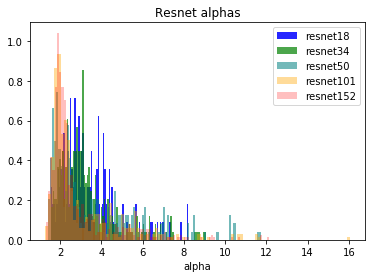

In [74]:
colors = ['blue', 'green', 'teal', 'orange', 'red']
transparency = 1.0
for im, details in enumerate(all_details):
    alphas = details.alpha.to_numpy()
    transparency -= 0.15
    
    plt.hist(alphas, bins=100, label=all_names[im], alpha=transparency, color=colors[im], density=True)
plt.legend()
plt.title("Resnet alphas")
plt.xlabel("alpha")

Text(0.5, 0, 'alpha')

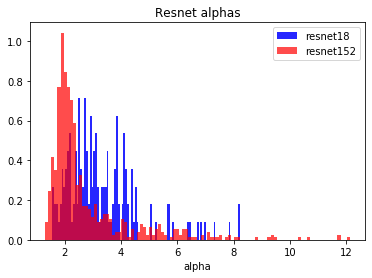

In [75]:
colors = ['blue', 'green', 'teal', 'orange', 'red']
transparency = 1.0
for im, details in enumerate(all_details):
    if im==0 or im == 4:
        alphas = details.alpha.to_numpy()
        transparency -= 0.15

        plt.hist(alphas, bins=100, label=all_names[im], alpha=transparency, color=colors[im], density=True)
plt.legend()
plt.title("Resnet alphas")
plt.xlabel("alpha")

Text(0.5, 0, 'log Frobenius Norm')

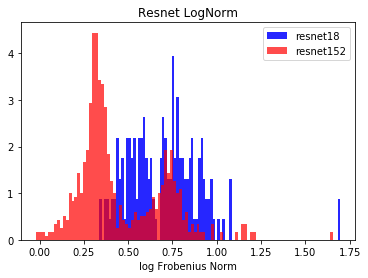

In [76]:
colors = ['blue', 'green', 'teal', 'orange', 'red']
transparency = 1.0
for im, details in enumerate(all_details):
    if im==0 or im == 4:
        logNorm = details.lognorm.to_numpy()
        transparency -= 0.15

        plt.hist(logNorm, bins=100, label=all_names[im], alpha=transparency, color=colors[im], density=True)
plt.legend()
plt.title("Resnet LogNorm")
plt.xlabel("log Frobenius Norm")

Text(0.5, 0, 'log Stable Rank')

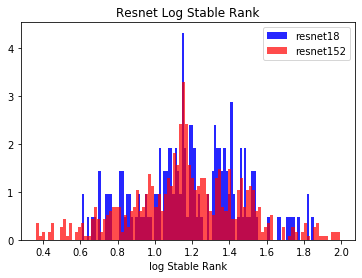

In [77]:
colors = ['blue', 'green', 'teal', 'orange', 'red']
transparency = 1.0
for im, details in enumerate(all_details):
    if im==0 or im == 4:
        logNorm = details.softranklog.to_numpy()
        transparency -= 0.15

        plt.hist(logNorm, bins=100, label=all_names[im], alpha=transparency, color=colors[im], density=True)
plt.legend()
plt.title("Resnet Log Stable Rank")
plt.xlabel("log Stable Rank")

In [78]:
all_details[0].head()

,layer_type,N,M,level,comment,norm,lognorm,alpha,alpha_weighted,spectralnorm,softrank,softranklog,softranklogratio,sigma_mp,numofSpikes,ratio_numofSpikes,softrank_mp,NxM
layer_id,,,,,,,,,,,,,,,,,,
7,CONV2D,64,64,LEVEL.SLICE,Slice level,2.50896,0.399494,2.08593,0.394013,1.54487,4.07471,0.610097,4.22988,0.964453,0,0,2.40841,4096
7,CONV2D,64,64,LEVEL.SLICE,Slice level,3.11053,0.492834,1.64773,0.259975,1.43806,6.72806,0.82789,6.24719,0.960352,0,0,2.56533,4096
7,CONV2D,64,64,LEVEL.SLICE,Slice level,2.56493,0.409076,2.049,0.229971,1.2949,5.08061,0.705916,7.2896,0.950293,0,0,2.78959,4096
7,CONV2D,64,64,LEVEL.SLICE,Slice level,3.24392,0.51107,1.61268,0.276545,1.48416,7.0902,0.850658,5.96063,0.961426,0,0,2.49121,4096
7,CONV2D,64,64,LEVEL.SLICE,Slice level,5.73808,0.758766,1.85414,1.67803,8.03563,4.09744,0.612512,1.67679,1.00576,3,0.047619,0.503536,4096


Text(0.5, 0, 'Log Spectral Norm')

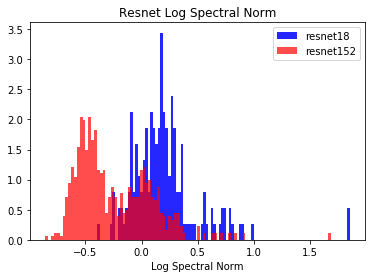

In [99]:
colors = ['blue', 'green', 'teal', 'orange', 'red']
transparency = 1.0
for im, details in enumerate(all_details):
    if im==0 or im == 4:
        logSpectralNorm = details.spectralnorm.to_numpy()
        logSpectralNorm = np.log10(np.array(logSpectralNorm+0.000001, dtype=np.float))
        transparency -= 0.15

        plt.hist(logSpectralNorm, bins=100, label=all_names[im], alpha=transparency, color=colors[im], density=True)
plt.legend()
plt.title("Resnet Log Spectral Norm")
plt.xlabel("Log Spectral Norm")

Text(0.5, 0, 'MP Soft Rank')

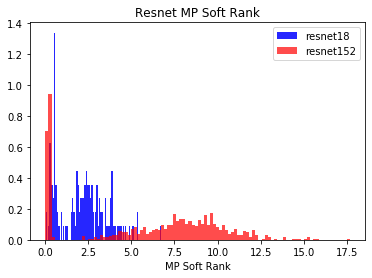

In [103]:
colors = ['blue', 'green', 'teal', 'orange', 'red']
transparency = 1.0
for im, details in enumerate(all_details):
    if im==0 or im == 4:
        MpSoftRank = details.softrank_mp.to_numpy()
        transparency -= 0.15

        plt.hist(MpSoftRank, bins=100, label=all_names[im], alpha=transparency, color=colors[im], density=True)
plt.legend()
plt.title("Resnet MP Soft Rank")
plt.xlabel("MP Soft Rank")